In [15]:
#Get recent tweets from financial influencers on twitter using Tweepy
influencers = ['elonmusk','CoinMarketCap','Cointelegraph','Gemini','wallstreetbets','krakenfx','coinbase']

#extract 15 tweets from each twitter user timeline
recent_twitter_df = pd.DataFrame()

for influencer in influencers:
    recent_posts = api.user_timeline(screen_name = influencer, count=10, tweet_mode='extended')
    data = pd.DataFrame( [tweet.full_text for tweet in recent_posts] , columns=['Tweets'])
    recent_twitter_df = recent_twitter_df.append(data)

#write to csv
recent_twitter_df.to_csv('Data/Functionality/Twitter/raw_twitter_data.csv')

#create a function to clean twitter posts
def clean_text(text):
    text= re.sub(r'@[A-Za-z0-9]+', '', text) #removes @mentions
    text = re.sub(r'#','', text) #removes the # symbol
    text = re.sub(r'RT[\s]+','', text) #removes RT
    text = re.sub(r'https?:\/\/\S+','', text) #removes hyperlink
    return text
#apply clean text
recent_twitter_df['Tweets'] = recent_twitter_df['Tweets'].apply(clean_text)
#write to csv
recent_twitter_df.to_csv('Data/Functionality/Twitter/twitter_clean_text_function.csv')

In [16]:
#create a function to get subjectivity and polarities
#subjectivity - how opinionated the text is
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity
    
#create a function to get polarity, how positive or negative the text is
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

#create two new columns
recent_twitter_df['Subjectivity'] = recent_twitter_df['Tweets'].apply(get_subjectivity)
recent_twitter_df['Polarity'] = recent_twitter_df['Tweets'].apply(get_polarity)

In [17]:
#create function to analyze polarity
def get_analysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
#create new column for analysis    
recent_twitter_df['Analysis'] = recent_twitter_df['Polarity'].apply(get_analysis)
#write to csv
recent_twitter_df.to_csv('Data/Functionality/Twitter/users_subjectivity_and_polarity.csv')

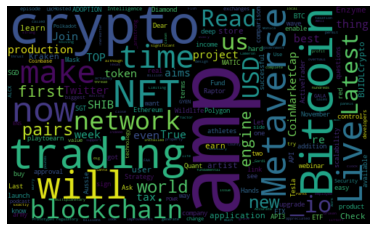

In [18]:
#plot Word Cloud users timelines
all_words = ' '.join( [twts for twts in recent_twitter_df['Tweets']] )
word_cloud = WordCloud(width = 500, height=300, random_state = 2, max_font_size = 119).generate(all_words)

plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [19]:
#Find general crypto sentiment using search terms on twitter - Uses Tweepy version 4

#Bearer_Token Authentication
bearer_token = os.getenv("bearer_token")
consumer_key = os.getenv("consumer_key")
consumer_secret_key = os.getenv("consumer_secret")
client = tweepy.Client(bearer_token)
#Authenticate account using consumer_key & consumer_secret_key
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret_key)
api = tweepy.API(auth)

In [20]:
#create new API search for recent tweets using a search term, then perform tone analysis to get market sentiment
query = 'crypto+market, -filter:retweets'
max_tweets = 25
posts = [status for status in tweepy.Cursor(api.search_tweets,q=query, lang='en', result_type='recent', count=25).items(max_tweets)]
#append posts in an array
string_array = []
for status in posts:
    string_array.append(status.text)
    
#put results into dataframe
query_tweets_df = pd.DataFrame(string_array, columns=['Tweets'])
#Write raw text to csv
query_tweets_df.to_csv('Data/Functionality/Twitter/query_tweets_raw.csv')

In [21]:
#Apply clean_text to search query tweets
query_tweets_df['Tweets'] = query_tweets_df['Tweets'].apply(clean_text)
#Write clean tweets to csv
query_tweets_df.to_csv('Data/Functionality/Twitter/query_tweets_clean_text.csv')

,Tweets
0,ICO GuestCrew Crypto GuestCoin This is a succe...
1,"Hello, if I may: I want to get into crypto+N..."
2,Market shifts can be opportunities for crypto ...
3,Crypto Market Strength\n\nSwing - 3.26%\n😨 ■□□...
4,Some say 2021 was the year of “dogs” for crypt...
5,"~ The Opportunity ~\n""The crypto market is wo..."
6,24-Hour Crypto Market Activity via LunarCrush\...
7,Crypto market’s bleeding red.\n\nI’ve no predi...
8,_io _Dep Many new projects make a good…
9,$starl is the most beautiful Metaverse crypto...


In [22]:
#Create new columns and apply subjectivity and polarity sentiment analysis
query_tweets_df['Subjectivity'] = query_tweets_df['Tweets'].apply(get_subjectivity)
query_tweets_df['Polarity'] = query_tweets_df['Tweets'].apply(get_polarity)

#Create new column for analysis of polarity  
query_tweets_df['Analysis'] = query_tweets_df['Polarity'].apply(get_analysis)

#Write to csv
query_tweets_df.to_csv('Data/Functionality/Twitter/market_sentiment_analysis.csv')

,Tweets,Subjectivity,Polarity,Analysis
0,ICO GuestCrew Crypto GuestCoin This is a succe...,0.475000,0.375000,Positive
1,"Hello, if I may: I want to get into crypto+N...",0.000000,0.000000,Neutral
2,Market shifts can be opportunities for crypto ...,1.000000,0.000000,Neutral
3,Crypto Market Strength\n\nSwing - 3.26%\n😨 ■□□...,0.000000,0.000000,Neutral
4,Some say 2021 was the year of “dogs” for crypt...,0.000000,0.000000,Neutral
5,"~ The Opportunity ~\n""The crypto market is wo...",0.100000,0.300000,Positive
6,24-Hour Crypto Market Activity via LunarCrush\...,0.066667,0.033333,Positive
7,Crypto market’s bleeding red.\n\nI’ve no predi...,0.000000,0.000000,Neutral
8,_io _Dep Many new projects make a good…,0.477273,0.318182,Positive
9,$starl is the most beautiful Metaverse crypto...,0.750000,0.675000,Positive


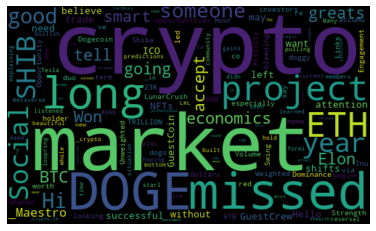

In [23]:
#plot word cloud to visualize tweets in conjunction with search query 
all_words = ' '.join( [twts for twts in query_tweets_df['Tweets']] )
word_cloud = WordCloud(width = 500, height=300, random_state = 2, max_font_size = 119).generate(all_words)

plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

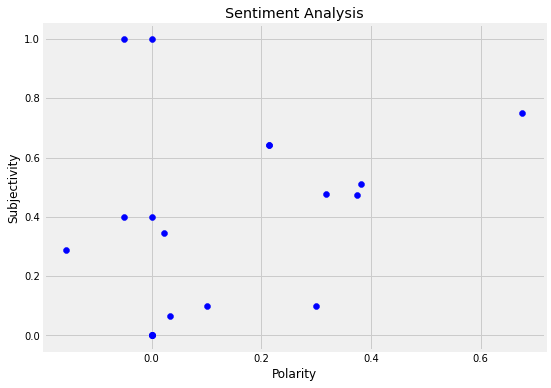

In [31]:
#plot the polarity and subjectivity 
plt.figure(figsize=(8,6))
for i in range(0, query_tweets_df.shape[0]):
    plt.scatter(query_tweets_df['Polarity'][i], query_tweets_df['Subjectivity'][i], color='blue' )
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [25]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
#authenticate IBM watson api connection & keys to use tone_analyzer
tone_api = os.getenv("tone_api")

#set_service_url is a private/personal endpoint url provided in your IBM-watson account, not publicly available
authenticator = IAMAuthenticator(tone_api)
tone_analyzer = ToneAnalyzerV3(
    version='2017-09-21',
    authenticator=authenticator
)
tone_analyzer.set_service_url('https://api.au-syd.tone-analyzer.watson.cloud.ibm.com/instances/85c20273-70b0-4277-b776-694e7146a612')

In [26]:
#create a document from query_tweets_df to run as single string through IBM tone_analyzer
full_text = " ".join( [tweets for tweets in query_tweets_df["Tweets"]] )
#print(full_text)

#Define text as string
text = full_text
# Analyze the text's tone with the 'tone()' method.
tone_analysis = tone_analyzer.tone(
    {"text": text},
    content_type="application/json",
    content_language="en",
    accept_language="en",
).get_result()
#Show sentiment results
#print(json.dumps(tone_analysis, indent=10)) 

ICO GuestCrew Crypto GuestCoin This is a successful project that has not left me without attention, I believe…    Hello, if I may: I want to get into crypto+NFTs and I need some ETH. I can trade this do…  Market shifts can be opportunities for crypto investors, especially if you’re a long-term holder looking to accumu…  Crypto Market Strength

Swing - 3.26%
😨 ■□□□□□□□□□ 😄

Dominance Weighted - 0.72%
😨 ■□□□□□□□□□ 😄

Unweighted - 5…  Some say 2021 was the year of “dogs” for crypto. The doggy duo Dogecoin (DOGE) and Shiba Inu (SHIB) led the meme co…   ~ The Opportunity ~
"The crypto market is worth over 2.5 TRILLION dollars..."  24-Hour Crypto Market Activity via LunarCrush

Social Volume 1.86M
Social Engagement 4.61B
Shared Links 258.23K
So…  Crypto market’s bleeding red.

I’ve no predictions for a bullish reversal (hoping) but I listened and learned to ta…  _io   _Dep   Many new projects make a good…   $starl is the most beautiful Metaverse crypto that u have ever seen. it have built up

In [27]:
#Get Document Tones as a whole (market sentiment)
doc_tone_df = json_normalize(data=tone_analysis["document_tone"], record_path=["tones"])
#doc_tone_df.head()


,score,tone_id,tone_name
0,0.683159,joy,Joy
1,0.513323,tentative,Tentative


In [29]:
# Sentences Tones (Get individual sentence sentement)
sentences_tone_df = json_normalize(
    data=tone_analysis["sentences_tone"],
    record_path=["tones"],
    meta=["sentence_id", "text"],
)
print(sentences_tone_df.head(20))

#write to csv
sentences_tone_df.to_csv('Data/Functionality/Twitter/sentences_tone.csv')

,score,tone_id,tone_name,sentence_id,text
0,0.588744,joy,Joy,0,ICO GuestCrew Crypto GuestCoin This is a succe...
1,0.775166,tentative,Tentative,0,ICO GuestCrew Crypto GuestCoin This is a succe...
2,0.524903,joy,Joy,1,I can trade this do… Market shifts can be opp...
3,0.788519,sadness,Sadness,3,Swing - 3.26%
4,0.798165,anger,Anger,3,Swing - 3.26%
5,0.751520,tentative,Tentative,9,Unweighted - 5… Some say 2021 was the year of...
6,0.532616,analytical,Analytical,10,The doggy duo Dogecoin (DOGE) and Shiba Inu (S...
7,0.601175,joy,Joy,11,"""The crypto market is worth over 2.5 TRILLION ..."
8,0.920855,analytical,Analytical,15,Shared Links 258.23K
9,0.874811,joy,Joy,17,I’ve no predictions for a bullish reversal (ho...


In [28]:
pytrends = TrendReq(hl= 'en-US')

list_a = nlp_cryptos[0:5]
list_b = nlp_cryptos[6:10]
list_c = nlp_cryptos[11:15]
list_d = nlp_cryptos[16:20]

google_topics = []
if len(list_a) > 0:
    google_topics.append(list_a)

if len(list_b) > 0:
    google_topics.append(list_b)

if len(list_c) > 0:
    google_topics.append(list_c)

if len(list_d) > 0:
    google_topics.append(list_d)

google_topics

In [ ]:
# List of cryptocurriences (only 5 crypto curriences at a time) pytrends gives a 400 error if more then 5 cryptocurreinces are added. 
total_df = pd.DataFrame()
# Instantiate SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


for list in google_topics:
        pytrends.build_payload(list, cat=0, timeframe='today 3-m', gprop='news')
        crypto_trends = pytrends.interest_over_time()
        crypto_trends=crypto_trends.drop(columns= 'isPartial')        
#         total_df['Trending Crypto']=crypto_trends.apply(lambda row:'_'.join(row[row.values>20].index), axis= 1)
        total_df = crypto_trends.join(total_df).dropna(how="any")
        crypto_trends.tail(10)

# Set current date and the date from one month ago using the ISO format
current_date = pd.Timestamp(datetime.now(), tz="America/New_York").isoformat()
past_date = pd.Timestamp(datetime.now()- timedelta(30), tz="America/New_York").isoformat()



# Use newsapi client to get most relevant headlines per day in the past month
def get_headlines(keyword):
    all_headlines = []
    all_dates = []    
    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date[:10], "%Y-%m-%d")
    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    while date > end_date:
        print(f"retrieving news from: {date}")
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date)[:10],
            to=str(date)[:10],
            language="en",
            sort_by="relevancy",
            page=1,
        )
        headlines = []
        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    return all_headlines, all_dates


    # Get first topic (kw = trending crypto)
crypto_headlines, dates = get_headlines("crypto")

# inflation headline
inflation_headlines, _ = get_headlines("inflation")

# Get third topic 
energy__headlines, _ = get_headlines("energy")


In [ ]:
# Create function that computes average compound sentiment of headlines for each day
def headline_sentiment_summarizer_avg(headlines):
    sentiment = []
    for day in headlines:
        day_score = []
        for h in day:
            if h == None:
                continue
            else:
                day_score.append(sid.polarity_scores(h)["compound"])
        sentiment.append(sum(day_score) / len(day_score))
    return sentiment

In [ ]:
# Get averages of each topics sentiment
crypto_choice_avg = headline_sentiment_summarizer_avg(crypto_headlines)
inflation_headlinese_avg = headline_sentiment_summarizer_avg(inflation_headlines)
energy__headlines_avg = headline_sentiment_summarizer_avg(energy__headlines)

In [ ]:
# Combine Sentiment Averages into DataFrame
topic_sentiments = pd.DataFrame(
    {
        "crypto_choice_avg": crypto_choice_avg,
        "inflation_headlinese_avg": inflation_headlinese_avg,
        "energy_consumption_avg": energy__headlines_avg,
    }
)

# Set the index value of the sentiment averages DataFrame to be the series of dates.
topic_sentiments.index = pd.to_datetime(dates)


# Merge with crypto df
topic_sentiments_trends = total_df.join(topic_sentiments).dropna(how="any")
topic_sentiments_trends.to_csv('Data/Functionality/Google/Sentiments.csv')
correlation_csv = topic_sentiments_trends.corr()
correlation_csv.to_csv('Data/Functionality/Google/Correlation.csv')
# display(topic_sentiments)


# Correlate the headlines' sentiment to returns
correlation_df = topic_sentiments_trends.corr().style.background_gradient(cmap='PuBu')
# print('Finished Extracting NLP Data')